In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ssm.util import softplus
from ssm.util import random_rotation

## Simulate Data

### Function for monotonic splines

In [2]:
hermite_basis = lambda t: (2*t**3-3*t**2+1,t**3-2*t**2+t,-2*t**3+3*t**2,t**3-t**2)

def spline_func(x,ps):
    delta_ys=softplus(ps)
    ys=np.cumsum(delta_ys)

    knots=np.array([-2,-1,0,1,2,3])
    idxs=np.argmax(x<knots,axis=1)-1
    x_l=knots[idxs,np.newaxis]

    h = np.diff(knots)
    h_rel = h[idxs,np.newaxis]

    h00,h10,h01,h11 = hermite_basis((x-x_l)/h_rel)

    secs=np.diff(ys)/h

    avg_secs=(secs[:-1]+secs[1:])/2
    tan_init = np.concatenate((secs[0:1],avg_secs,secs[-1:]))

    alpha = tan_init[:-1]/(secs+.001)
    beta = tan_init[1:]/(secs+.001) # to k-2


    # Check for monotonicity:
    cond = alpha**2+beta**2

    inc1=np.hstack((cond<9,np.array([1])))
    inc2=np.hstack((np.array([1]),cond<9))

    tan_init2=inc1*inc2*tan_init+(1-inc1)*np.hstack((3./np.sqrt(cond)*alpha*secs,np.array([1])))+(1-inc2)*np.hstack((np.array([1]),3./np.sqrt(cond)*beta*secs))

    return ys[idxs,np.newaxis]*h00+h_rel*tan_init2[idxs,np.newaxis]*h10+ys[idxs+1,np.newaxis]*h01+h_rel*tan_init2[idxs+1,np.newaxis]*h11


### Simulate latent space and neural activity

In [3]:
N=5
n_kn=6
ps=np.random.randn(N,n_kn)
ps2=np.random.randn(N,n_kn)

ys_all=[]
xs_all=[]
xs2_all=[]

n_tr=1
t_end=1000
for tr in range(n_tr):
    xs=np.zeros([t_end,1])
    xs[0]=5
    for t in range(t_end):
        xs[t]=xs[t-1]+0.5*np.random.randn(1)
    xs=(xs-np.min(xs))/(np.max(xs)-np.min(xs))*4-1.5
    xs_all.append(xs)

    xs2=np.zeros([t_end,1])
    xs2[0]=5
    for t in range(t_end):
        xs2[t]=xs2[t-1]+0.5*np.random.randn(1)
    xs2=(xs2-np.min(xs2))/(np.max(xs2)-np.min(xs2))*4-1.5
    xs2_all.append(xs2)    
    
    ys_temp=[spline_func(xs,p) for p in ps]    
    ys=np.hstack(ys_temp)

    ys_temp2=[spline_func(xs2,p2) for p2 in ps2]    
    ys2=np.hstack(ys_temp2)
    
    ys_all.append(ys*ys2/4)

### Plot Latent Space

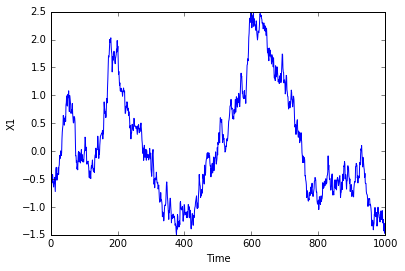

In [63]:
plt.plot(xs_all[0])
plt.xlabel('Time')
plt.ylabel('X1')

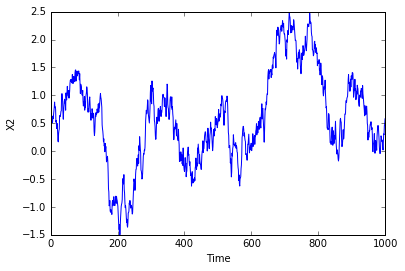

In [64]:
plt.plot(xs2_all[0])
plt.xlabel('Time')
plt.ylabel('X2')

### Plot Neural Activity

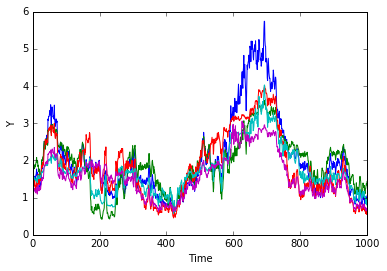

In [65]:
plt.plot(ys_all[0])
plt.xlabel('Time')
plt.ylabel('Y')

### Plot f's

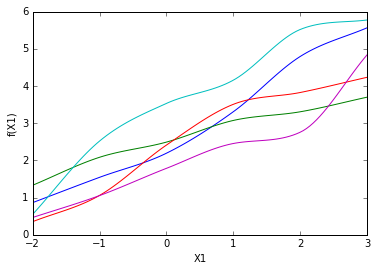

In [66]:
xs_temp=np.linspace(-2,3,num=100)[:,np.newaxis]

for i in range(N):
    output=spline_func(xs_temp,ps[i,:])
    plt.plot(xs_temp,output)
plt.xlabel('X1')
plt.ylabel('f(X1)')

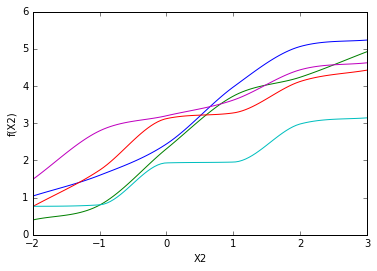

In [67]:
for i in range(N):
    output=spline_func(xs_temp,ps2[i,:])
    plt.plot(xs_temp,output)
plt.xlabel('X2')
plt.ylabel('f(X2)')

## Fit the model with 2 latents

In [47]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior
from ssm.models import LDS, SLDS
from ssm.util import random_rotation, find_permutation

In [48]:
# lds = LDS(N=N,D=1,emissions="gaussian_spline")
lds = SLDS(N=N,D=2,K=1,emissions="gaussian_spline")

In [49]:
lds.initialize(ys)
q = SLDSMeanFieldVariationalPosterior(lds, ys_all, initial_variance=.001)
# elbos = lds.fit(q, ys_all, num_iters=10000, print_intvl=10, initialize=False, method='svi')
elbos = lds.fit(q, ys_all, num_iters=15000, print_intvl=10, initialize=False, method='vem')

# lds_cons_x = q.mean[0]

Initializing with an ARHMM using 25 steps of EM.



/Users/jig289/anaconda/envs/py35/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/jig289/anaconda/envs/py35/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.concatenate((-g[sl1], -anp.diff(g, axis=axis), g[sl2]), axis=axis)


## Look at Model output

### Latent Space

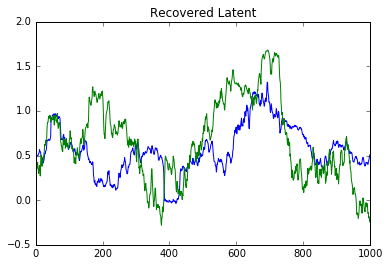

In [50]:
plt.plot(q.mean[0])
plt.title('Recovered Latent')

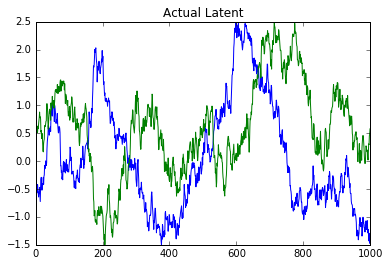

In [51]:
plt.plot(xs_all[0])
plt.plot(xs2_all[0])
plt.title('Actual Latent')

### Goodness of fit of neurons

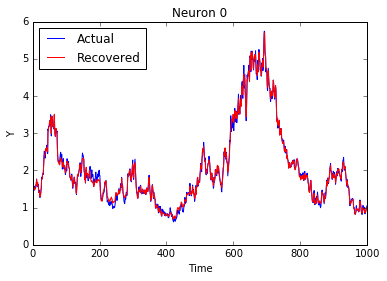

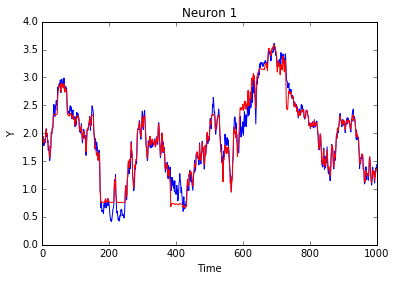

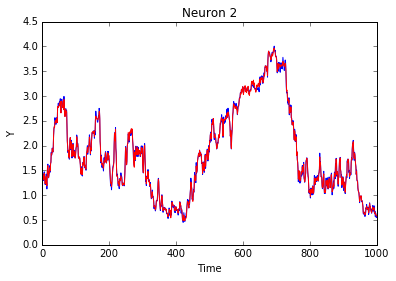

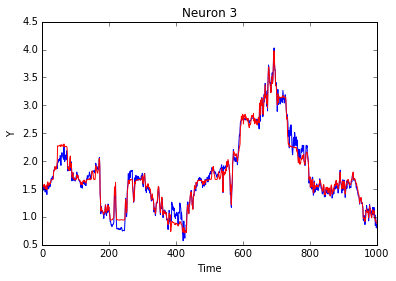

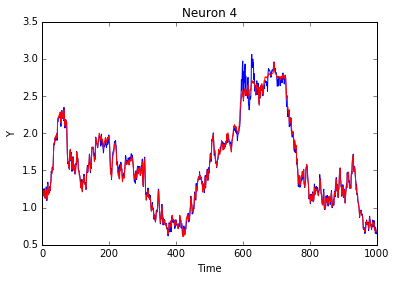

In [71]:
for i in range(5):
    plt.figure()
    plt.plot(ys_all[0][:,i])
    plt.plot(lds.smooth(q.mean[0],ys_all[0])[:,i],'r')
    plt.title('Neuron '+str(i))
    plt.xlabel('Time')
    plt.ylabel('Y')
    if i==0:
        plt.legend(['Actual','Recovered'],loc=0)

### Functions

In [19]:
def spline_func2(x,ps):
    delta_ys=softplus(ps)
    ys=np.cumsum(delta_ys)

    knots=np.array([-3,-1,-0.6,-0.2,0,.2,.4,.6,.8,1,1.2,1.6,2,4])
    idxs=np.argmax(x<knots,axis=1)-1
    x_l=knots[idxs,np.newaxis]

    h = np.diff(knots)
    h_rel = h[idxs,np.newaxis]

    h00,h10,h01,h11 = hermite_basis((x-x_l)/h_rel)

    secs=np.diff(ys)/h

    avg_secs=(secs[:-1]+secs[1:])/2
    tan_init = np.concatenate((secs[0:1],avg_secs,secs[-1:]))

    alpha = tan_init[:-1]/(secs+.001)
    beta = tan_init[1:]/(secs+.001) # to k-2


    # Check for monotonicity:
    cond = alpha**2+beta**2

    inc1=np.hstack((cond<9,np.array([1])))
    inc2=np.hstack((np.array([1]),cond<9))

    tan_init2=inc1*inc2*tan_init+(1-inc1)*np.hstack((3./np.sqrt(cond)*alpha*secs,np.array([1])))+(1-inc2)*np.hstack((np.array([1]),3./np.sqrt(cond)*beta*secs))

    return ys[idxs,np.newaxis]*h00+h_rel*tan_init2[idxs,np.newaxis]*h10+ys[idxs+1,np.newaxis]*h01+h_rel*tan_init2[idxs+1,np.newaxis]*h11


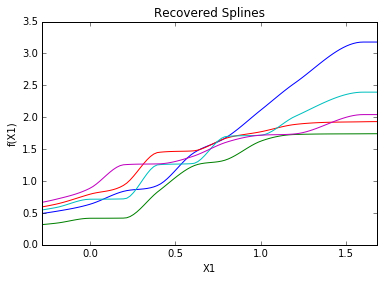

In [72]:
xs_temp1=np.linspace(np.min(q.mean[0]),np.max(q.mean[0]),num=100)[:,np.newaxis]
for i in range(N):
    output1=spline_func2(xs_temp1,lds.emissions.ps[i][:,0])
    plt.plot(xs_temp1,output1)
plt.xlim([np.min(q.mean[0]),np.max(q.mean[0])])
plt.title('Recovered Splines')
plt.xlabel('X1')
plt.ylabel('f(X1)')

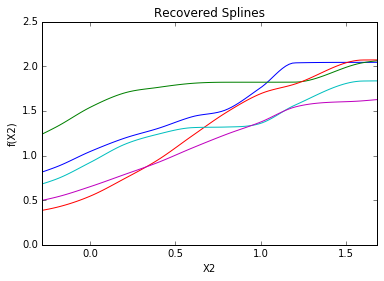

In [73]:
xs_temp1=np.linspace(np.min(q.mean[0]),np.max(q.mean[0]),num=100)[:,np.newaxis]
for i in range(N):
    output1=spline_func2(xs_temp1,lds.emissions.ps[i][:,1])
    plt.plot(xs_temp1,output1)
plt.xlim([np.min(q.mean[0]),np.max(q.mean[0])])
plt.title('Recovered Splines')
plt.xlabel('X2')
plt.ylabel('f(X2)')

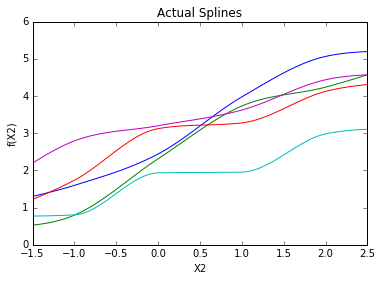

In [74]:
xs_temp2=np.linspace(-1.5,2.5,num=100)[:,np.newaxis]
for i in range(N):
    output=spline_func(xs_temp2,ps2[i])
    plt.plot(xs_temp2,output)
plt.title('Actual Splines')
plt.xlabel('X2')
plt.ylabel('f(X2)')

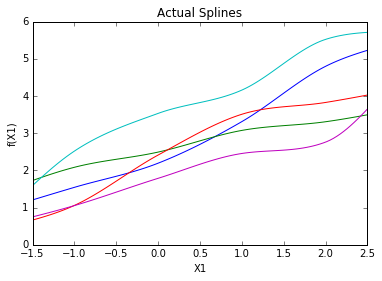

In [75]:
xs_temp2=np.linspace(-1.5,2.5,num=100)[:,np.newaxis]
for i in range(N):
    output=spline_func(xs_temp2,ps[i])
    plt.plot(xs_temp2,output)
plt.title('Actual Splines')
plt.xlabel('X1')
plt.ylabel('f(X1)')

## Fit model w/ 1 latent

In [31]:
# lds = LDS(N=N,D=1,emissions="gaussian_spline")
lds1 = SLDS(N=N,D=1,K=1,emissions="gaussian_spline")

In [83]:
lds1.initialize(ys)
q1 = SLDSMeanFieldVariationalPosterior(lds1, ys_all, initial_variance=.001)
# elbos = lds.fit(q, ys_all, num_iters=10000, print_intvl=10, initialize=False, method='svi')
elbos = lds1.fit(q1, ys_all, num_iters=15000, print_intvl=10, initialize=False, method='vem')


Initializing with an ARHMM using 25 steps of EM.



/Users/jig289/anaconda/envs/py35/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Users/jig289/anaconda/envs/py35/lib/python3.5/site-packages/autograd/numpy/numpy_vjps.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.concatenate((-g[sl1], -anp.diff(g, axis=axis), g[sl2]), axis=axis)


## Show Goodness of Fit of both models

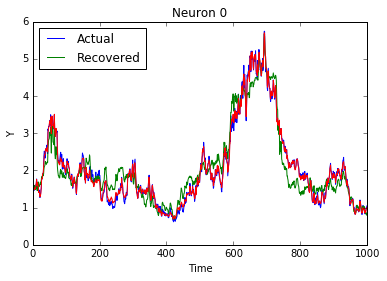

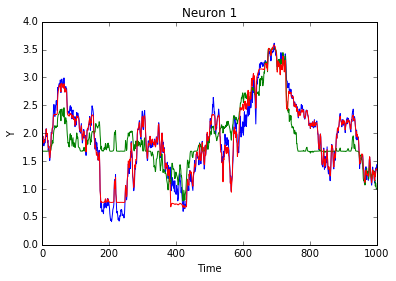

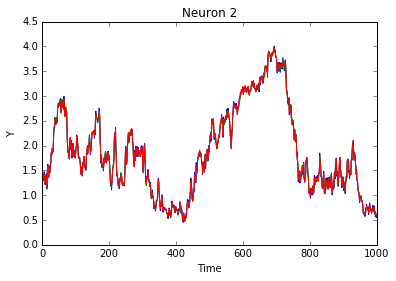

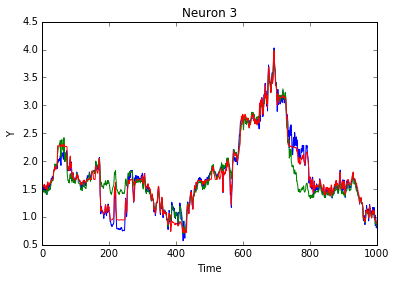

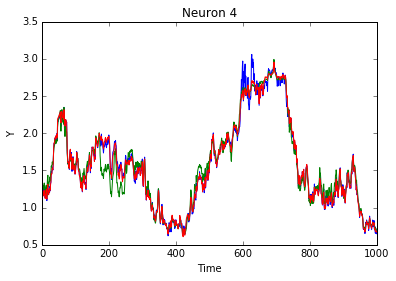

In [85]:
for i in range(5):
    plt.figure()
    plt.plot(ys_all[0][:,i])
    plt.plot(lds1.smooth(q1.mean[0],ys_all[0])[:,i])
    plt.plot(lds.smooth(q.mean[0],ys_all[0])[:,i])
    plt.title('Neuron '+str(i))
    plt.xlabel('Time')
    plt.ylabel('Y')
    if i==0:
        plt.legend(['Actual','Recovered'],loc=0)

## Neuron vs Neuron Plots

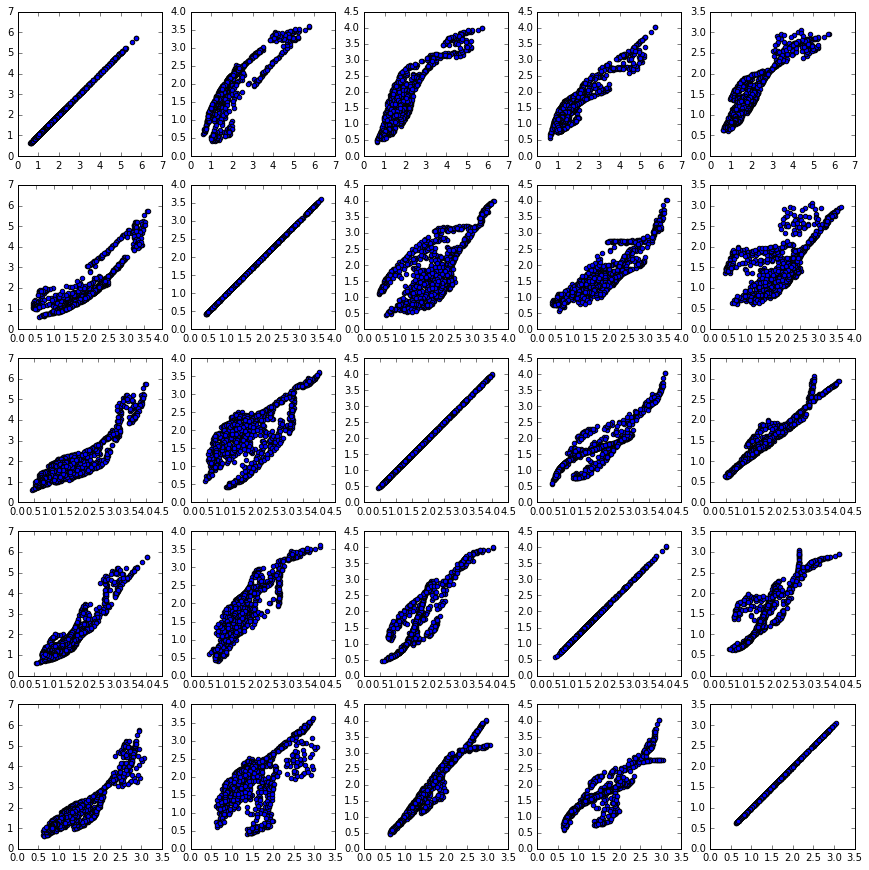

In [95]:
fig,ax=plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(ys_all[0][:,i],ys_all[0][:,j])

#### 2 Latent Model Predictions

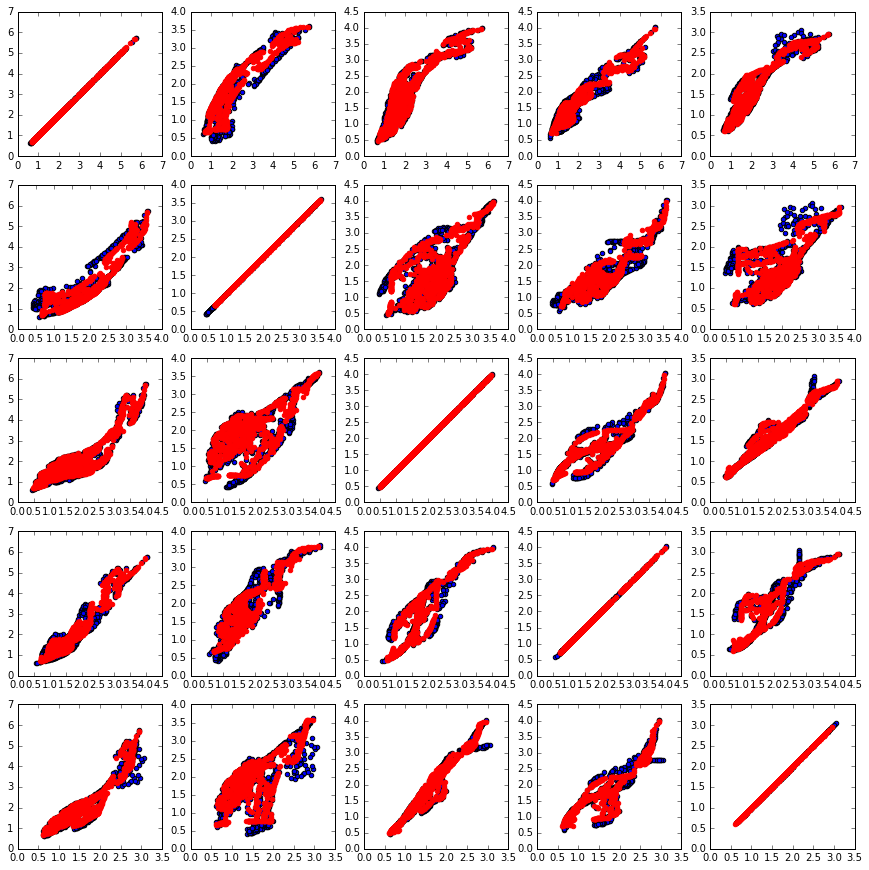

In [91]:
ypred2=lds.smooth(q.mean[0],ys_all[0])

fig,ax=plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(ys_all[0][:,i],ys_all[0][:,j])
        ax[i,j].scatter(ypred2[:,i],ypred2[:,j],color='r')

#### 1 Latent Model Predictions

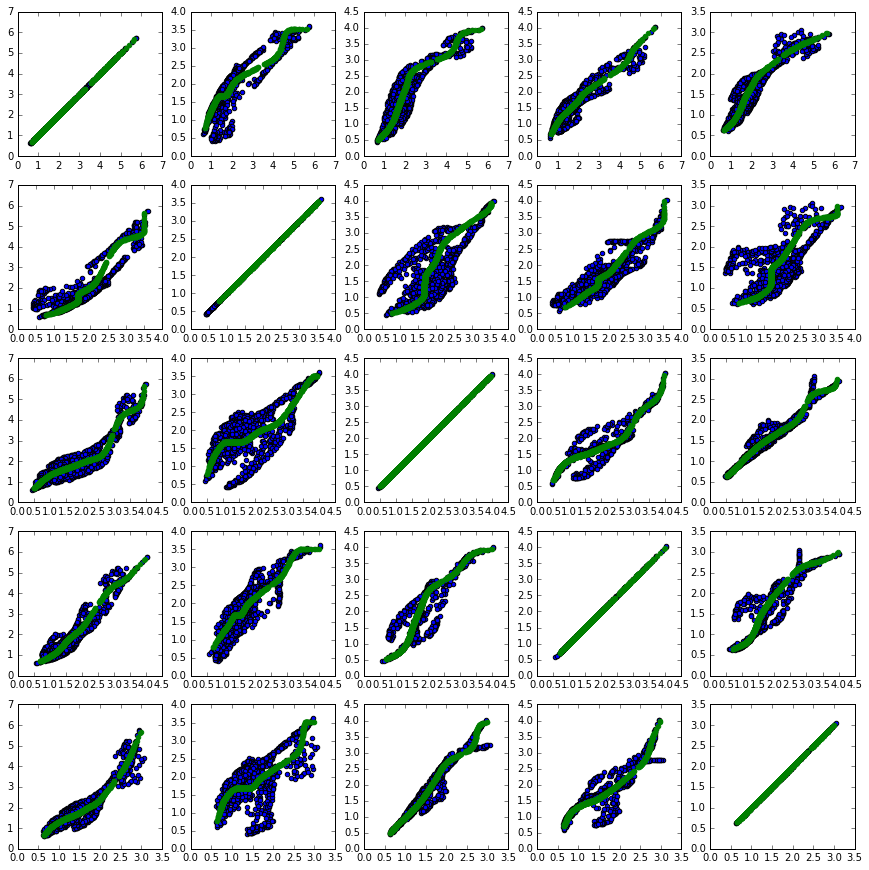

In [92]:
ypred1=lds1.smooth(q1.mean[0],ys_all[0])

fig,ax=plt.subplots(5,5,figsize=(15,15))
for i in range(5):
    for j in range(5):
        ax[i,j].scatter(ys_all[0][:,i],ys_all[0][:,j])
        ax[i,j].scatter(ypred1[:,i],ypred1[:,j],color='g')